In [38]:
import collections

import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [36]:
train_ds, val_ds = tfds.load('svhn_cropped', split=['train[:80%]', 'train[80%:]'])
test_ds = tfds.load('svhn_cropped', split='test')
len(train_ds), len(val_ds), len(test_ds)

(58606, 14651, 26032)

(<matplotlib.image.AxesImage at 0x7709401f3c10>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>)

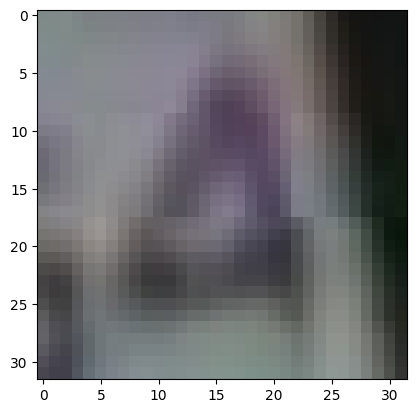

In [37]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['label']

In [123]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element['label']
        image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(128)
            .batch(512)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(512)
        )

In [124]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

In [105]:
def augment(image):
    image = tf.image.random_brightness(image, max_delta=.2)
    image = tf.image.random_contrast(image, .2, .5)
    # image = tf.image.random_saturation(image, )
    return image

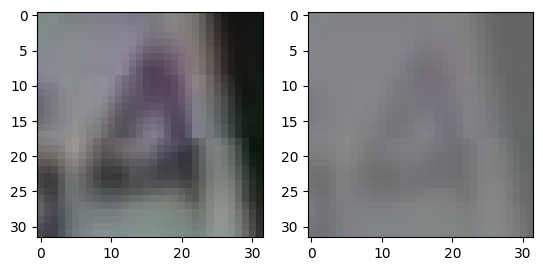

In [117]:
img = next(iter(train_ds))['image']
augmented_img = augment(tf.cast(img, dtype=tf.float32) / 255.)
fig, axes = plt.subplots(1,2)
axes[0].imshow(img)
axes[1].imshow(augmented_img)

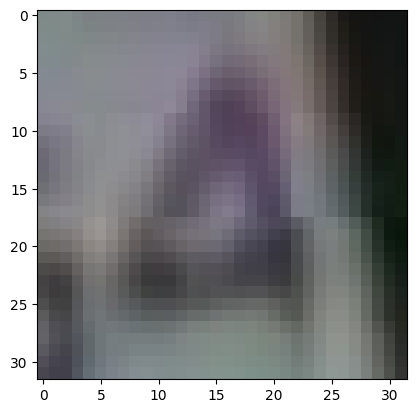

In [80]:
plt.imshow(tf.cast(img, dtype=tf.float32) / 255.)

In [154]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape(input_shape=(32, 32, 3), target_shape=(32 * 32 * 3,)),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(10),
])

In [155]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss=loss_object, metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')], run_eagerly=True)

In [156]:
model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
115/115 [==============================] - 5s 39ms/step - loss: 2.2206 - accuracy: 0.2004 - val_loss: 2.1640 - val_accuracy: 0.2315
Epoch 2/10
115/115 [==============================] - 4s 36ms/step - loss: 2.0830 - accuracy: 0.2781 - val_loss: 1.9840 - val_accuracy: 0.3297
Epoch 3/10
115/115 [==============================] - 5s 40ms/step - loss: 1.8730 - accuracy: 0.3851 - val_loss: 1.7756 - val_accuracy: 0.4271
Epoch 4/10
115/115 [==============================] - 4s 38ms/step - loss: 1.6693 - accuracy: 0.4734 - val_loss: 1.5986 - val_accuracy: 0.4990
Epoch 5/10
115/115 [==============================] - 4s 34ms/step - loss: 1.5130 - accuracy: 0.5366 - val_loss: 1.4667 - val_accuracy: 0.5516
Epoch 6/10
115/115 [==============================] - 4s 36ms/step - loss: 1.3997 - accuracy: 0.5799 - val_loss: 1.3726 - val_accuracy: 0.5805
Epoch 7/10
115/115 [==============================] - 4s 33ms/step - loss: 1.3152 - accuracy: 0.6092 - val_loss: 1.3030 - val_accuracy: 0.6026